In [1]:
import os
os.chdir(os.pardir)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib.patches as mpatches
import pandas as pd

import vapor
from vapor.models import Cambium

2020-11-17 11:28:52,089 [MainThread  ] [INFO ]  Starting log for vapor...


In [2]:
os.getcwd()

'/srv/data/home/skoebric/vapor-open'

In [3]:
# --- Load Regional Best ---
results = pd.read_pickle(os.path.join('results','bnef_results.pkl'))
results['scenario'] = 'Mid Cost'
results['batt_size'] = 0
results.rename({'geometry':'point', 'region':'pca'}, axis='columns', inplace=True)


In [5]:
# --- Merge on Regions ---
region_map = pd.read_csv(os.path.join('data','geography','region_hierarchy.csv'))
region_map = region_map[['pca','rto','census_reg','inter']].drop_duplicates()

census_reg_dict = {
    'PA':'West',
    'MTN':'West',
    'ENC':'Midwest',
    'WNC':'Midwest',
    'WSC':'South',
    'MA':'Northeast',
    'NE':'Northeast',
    'ESC':'South',
    'SA':'South'
}
region_map['census_div'] = region_map['census_reg'].map(census_reg_dict)

df = results.merge(region_map, on='pca', how='left')


In [7]:
years = [str(i) for i in range(2014,2051,1)]
cambium_cols = [i for i in df.columns if 'cambium' in i]
cambium_cols = [i for i in cambium_cols if i[-4:] in years]


# --- subset cambium columns ---
c_df = df[cambium_cols + list(region_map.columns) + ['project_id','tech','system_capacity']]

# --- melt ---
c_df = c_df.melt(id_vars= list(region_map.columns) +['project_id','tech','system_capacity'])
c_df['year'] = [int(i[-4:]) for i in c_df['variable']]
c_df['variable'] = [str(i[:-5]) for i in c_df['variable']]

c_df['value_mw'] = c_df['value'] / c_df['system_capacity'] * 1000


In [33]:
c_df.loc[\
         (c_df['variable'] == 'cambium_co2_rate_avg') &\
         (c_df['year'] == 2020)\
        ].sort_values('value', ascending=False)

,pca,rto,census_reg,inter,census_div,project_id,tech,system_capacity,variable,value,year,value_mw
10678,p64,rto10,WSC,texas,South,10000035,pv,767000.0,cambium_co2_rate_avg,661980.379865,2020,863.077418
10724,p103,rto6,ENC,eastern,Midwest,10000129,pv,429000.0,cambium_co2_rate_avg,436455.982638,2020,1017.379913
10667,p25,rto2,MTN,western,West,10000014,pv,362700.0,cambium_co2_rate_avg,395410.771120,2020,1090.186852
10700,p57,rto8,WSC,eastern,South,10000087,pv,325000.0,cambium_co2_rate_avg,322864.444235,2020,993.429059
10418,p112,rto7,ENC,eastern,Midwest,126489,wind,189000.0,cambium_co2_rate_avg,244046.182782,2020,1291.249644
...,...,...,...,...,...,...,...,...,...,...,...,...
10587,p18,rto2,MTN,western,West,188265,wind,80000.0,cambium_co2_rate_avg,0.000000,2020,0.000000
10588,p18,rto2,MTN,western,West,188275,wind,80000.0,cambium_co2_rate_avg,0.000000,2020,0.000000
10290,p18,rto2,MTN,western,West,98194,wind,80000.0,cambium_co2_rate_avg,0.000000,2020,0.000000
10615,p120,rto7,MA,eastern,Northeast,209445,pv,91000.0,cambium_co2_rate_avg,0.000000,2020,0.000000


In [45]:

value_col = 'value'
grouped = c_df.groupby(['census_div','tech','year','variable'], as_index=False)[['system_capacity',value_col]].sum()
grouped['census_div'] = pd.Categorical(grouped['census_div'], categories=['Northeast','West','Midwest','South'], ordered=True)
grouped.sort_values('census_div', inplace=True)

grouped = grouped.loc[grouped['year'] == 2020]
grouped = grouped.loc[grouped['variable'].isin(['cambium_co2_rate_avg','cambium_grid_value'])]
grouped = grouped.loc[grouped['value'] > 0]

pivot = grouped.pivot_table(
    index=['census_div','tech'],
    columns='variable',
    values='value'
)
pivot.reset_index(inplace=True)

sc = grouped[['census_div', 'tech', 'system_capacity']].drop_duplicates()

pivot = pivot.merge(sc, on=['tech','census_div'])

pivot['cambium_co2_rate_avg'] /= 2000
pivot['cambium_grid_value']  /= 1e3
pivot['system_capacity'] /= 1000

pivot.to_csv(os.path.join('images','existing_impacts.csv'))
pivot.sum()


tech                    pvwindpvwindpvwindpvwind
cambium_co2_rate_avg                     8293.13
cambium_grid_value                       2143.88
system_capacity                            36549
dtype: object

In [29]:
grouped

,census_div,tech,year,variable,system_capacity,value
283,Northeast,pv,2020,cambium_grid_value,1424300.0,8.904426e+04
282,Northeast,pv,2020,cambium_co2_rate_avg,1424300.0,3.956852e+05
418,Northeast,wind,2020,cambium_grid_value,209200.0,1.235259e+04
417,Northeast,wind,2020,cambium_co2_rate_avg,209200.0,7.351708e+04
957,West,wind,2020,cambium_co2_rate_avg,1174100.0,3.480580e+05
958,West,wind,2020,cambium_grid_value,1174100.0,4.723300e+04
822,West,pv,2020,cambium_co2_rate_avg,4199900.0,2.129552e+06
823,West,pv,2020,cambium_grid_value,4199900.0,2.364432e+05
147,Midwest,wind,2020,cambium_co2_rate_avg,7071600.0,5.062556e+06
148,Midwest,wind,2020,cambium_grid_value,7071600.0,4.844405e+05


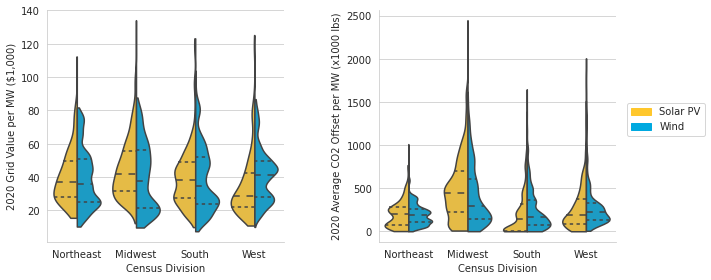

In [34]:
dist = c_df.copy()
# dist['census_div'] = pd.Categorical(dist['census_div'], categories=['Northeast','West','Midwest','South'], ordered=True)
# dist.sort_values('census_div', inplace=True)


sns.set_style('whitegrid')
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))

grid_value = dist.loc[dist['variable'] == 'cambium_grid_value']
co2 = dist.loc[dist['variable'] == 'cambium_co2_rate_avg']

sns.set_palette(sns.color_palette([vapor.tech_dict['pv'], vapor.tech_dict['wind']]))

sns.violinplot(
    data=grid_value, x='census_div', y='value_mw',
    hue='tech', split=True, inner='quart',
    ax=ax1, cut=0, scale='area'
  )

sns.violinplot(
    data=co2, x='census_div', y='value_mw',
    hue='tech', split=True, inner='quart', 
    ax=ax2, cut=0, scale='width'
  )

ax1.set_ylabel('2020 Grid Value per MW ($1,000)')
ax2.set_ylabel('2020 Average CO2 Offset per MW (x1000 lbs)')
ax1.set_xlabel('Census Division')
ax2.set_xlabel('Census Division')

ax1.legend([],[], frameon=False)
ax2.legend([],[], frameon=False)

label_dict = {'pv':'Solar PV', 'wind':'Wind'}
custom_patches = [mpatches.Patch(color=vapor.tech_dict[k], label=v) for k,v in label_dict.items()]
plt.legend(handles=custom_patches, bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
sns.despine()

# g = sns.catplot(x='census_div', y='value_mw',
#                 hue='tech', col='variable',
#                data=dist, kind='violin', split=True, bw=.3,
#                height=5, aspect=1.2, sharey=False)


In [ ]:
set(dist)

In [ ]:
bars.pivot_table(index='census_div', columns='tech', values='value').plot.bar(stacked=True)

In [ ]:
# --- plot ---
g_df = c_df.groupby(['year','variable','tech'], as_index=False)['value'].sum()
g_df = g_df.loc[g_df['variable'] == 'cambium_total_value']
sns.lineplot(x='year', y='value', hue='tech', data=g_df)
